In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
from importlib import reload
from pathlib import Path
import scanpy as sc
from pylab import rcParams
from matplotlib.patches import Patch
import re
import seaborn as sns
import glob

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.2.2 (python 3.8.3) on 2021-04-27 12:04.


In [2]:
def adata_louvain_name_convert(inputAdata, orderDf, louvainNewOrdered, louvainOldOrdered):
    inputAdata.obs["louvain_celltype"] = ["%s_%s"%(x,y) for index, (x,y) in enumerate(zip(inputAdata.obs['louvain'], inputAdata.obs['cell_type']))]
    inputAdata.obs["celltype_general"] = [x[0] for x in inputAdata.obs['cell_type']]
    
    #--- Match old & new louvain levels
    inputAdata.obs['louvain_old'] = inputAdata.obs['louvain']
    inputAdata.uns['louvain_old_colors'] = inputAdata.uns['louvain_colors']
    inputAdata.obs['louvain'] = [ louvainNewOrdered[louvainOldOrdered.index(int(x))] for x in inputAdata.obs['louvain'] ]
    category_order = orderDf.sort_values('louvain')['louvain_new_label'].tolist()
    category_order = [x for x in category_order if x in np.unique(inputAdata.obs['louvain'])]
    inputAdata.obs['louvain'] = pd.Categorical(inputAdata.obs['louvain'].tolist(), categories=category_order) # The key is to set categories according to original order...

    inputAdata.obs['Infection type'] = [ 'Armstrong' if 'A' in x else 'Clone13' if 'C' in x else 'Naive' for x in inputAdata.obs['cell_type']]

In [3]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/plotting_codes","")
    tools_dir = base_dir + "/tools"

    sys.path.insert(1, tools_dir)
    import sc_addons
    import sc_pl_addons
else:
    print("Reload")
    reload(sc_addons)
    reload(sc_pl_addons)

Start


In [36]:
def layer_group_average_slt_genes(adata_use, layer_use, genes_use, group_use, group_order, key):
    df = pd.DataFrame(adata_use.layers[layer_use])
    df.columns = adata_use.var.index
    genes_use = [x for x in genes_use if x in df.columns.tolist()]
    df = df[genes_use]
    df[group_use] = adata_use.obs[group_use].tolist()
    df_mean = df.groupby(group_use).mean().T
    group_order_use = [x for x in group_order if x in df_mean.columns.tolist()]
    df_mean = df_mean[group_order_use]
    df_mean.columns = ["%s_%s"%(key, x) for x in df_mean.columns]
    return(df_mean)

In [4]:
## ----- Setup working dir
sp_name = "1_IL2RAKO"
analysis_name = ["0", "all"] 

wk_dir = base_dir + "/9_Figures/%s/%s_%s/scVelo"%(sp_name, analysis_name[0], analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wk_dir)

print(sp_name)

1_IL2RAKO


In [5]:
###----- old - new cluster names
order_file = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/1_Scanpy/0-all_Scanpy_out/0_sum/1_IL2RAKO_obs_louvainAvg.csv'
order_df = pd.read_csv(order_file)
louvain_new_ordered = order_df['louvain_new_label'].tolist()
louvain_old_ordered = order_df['louvain'].tolist()

In [6]:
all_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/2_scVelo/0-all_Dyn_scVelo_out/1_IL2RAKO_scVelo.h5ad'
adata = scv.read(all_h5ad)

act_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/2_scVelo/1-ACTonly_Dyn_scVelo_out/1_IL2RAKO_scVelo.h5ad'
adata_act = scv.read(act_h5ad)
adata_act_oldnames = adata_act.copy()

act_wt_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/2_scVelo/2-actWT_Dyn_scVelo_out/1_IL2RAKO_scVelo.h5ad'
adata_act_wt = scv.read(act_wt_h5ad)
adata_act_wt_oldnames = adata_act_wt.copy()

act_ko_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/2_scVelo/2-actKO_Dyn_scVelo_out/1_IL2RAKO_scVelo.h5ad'
adata_act_ko = scv.read(act_ko_h5ad)
adata_act_ko_oldnames = adata_act_ko.copy()

#--- Match old & new louvain levels
adata_louvain_name_convert(adata, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_act, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_act_wt, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_act_ko, order_df, louvain_new_ordered, louvain_old_ordered)

adata.uns['louvain_colors'] = ['slategray',  'orchid','orange', 'sienna', 'dodgerblue','dimgray',  'lightgray' ,'purple', 'forestgreen','red']
adata_act.uns['louvain_colors'] = ['slategray',  'orchid','orange', 'sienna', 'dodgerblue','dimgray',  'lightgray' ,'purple', 'forestgreen','red']
adata_act_wt.uns['louvain_colors'] = ['slategray',  'orchid','orange', 'sienna', 'dodgerblue','dimgray',  'lightgray' ,'purple', 'forestgreen','red']
adata_act_ko.uns['louvain_colors'] = ['slategray',  'orchid','orange', 'sienna', 'dodgerblue','dimgray',  'lightgray' ,'purple', 'forestgreen','red']

In [7]:
color_dict = {x:y for index, (x,y) in enumerate(zip(adata.obs.louvain.cat.categories.tolist(), adata.uns['louvain_colors']))}
color_dict

{'P0': 'slategray',
 'P1': 'orchid',
 'P6': 'orange',
 'P5': 'sienna',
 'P4': 'dodgerblue',
 'P0.2': 'dimgray',
 'P0.1': 'lightgray',
 'P7': 'purple',
 'P3': 'forestgreen',
 'P2': 'red'}

In [8]:
paga_xmax, paga_ymax = np.amax(adata.obsm['paga'], axis=0)
paga_xmin, paga_ymin = np.amin(adata.obsm['paga'], axis=0)
paga_dx, paga_dy = paga_xmax - paga_xmin, paga_ymax - paga_ymin
paga_xmax, paga_xmin = paga_xmax + paga_dx*0.1, paga_xmin - paga_dx*0.1
paga_ymax, paga_ymin = paga_ymax + paga_dy*0.1, paga_ymin - paga_dy*0.1

In [9]:
### Intersect chromatin regulators & TF & cell surface receptors
surface_df = pd.read_csv('https://raw.githubusercontent.com/Yolanda-HT/SurfaceMarkers_Cytokines/master/2_compiled/MM_MARKERS.csv')
surface_genes = surface_df['gene_name'].tolist()
crf_df = pd.read_csv('https://raw.githubusercontent.com/ScrippsPipkinLab/CRF_Screen/master/Ref/CRF_all.csv?token=AGIX2O34XB535HOMHYLMOIDAC4FJU')
crf_genes = crf_df['gene_name'].tolist() + [x for x in crf_df['Alternative'].tolist() if str(x) != 'nan']
tf_df = pd.read_csv('https://raw.githubusercontent.com/Yolanda-HT/TFclassDataCollection/master/Ravasi_TF.csv')
tf_genes = tf_df['symbol'].tolist()
all_genes = list(set(surface_genes + crf_genes + tf_genes))

### Gene signature genes
gs_plot_use_file = '/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/Y_annotated/anno_plotuse_gs_20200928.csv'
gs_plot_use_df = pd.read_csv(gs_plot_use_file)
gs_use = gs_plot_use_df[gs_plot_use_df['plot_use'].notnull()]['gs_name'].tolist()

gs_file = '/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/X_GeneSignatures_mm/all_mouse_T_cell_signatures.csv'
gs_df = pd.read_csv(gs_file)
gs_df_use = gs_df[[True if x in gs_use else False for x in gs_df['gs_name']]]
genes_use = list(set(gs_df_use['gene_symbol'].tolist()))

genes_use = [i for i in genes_use if i in all_genes]

In [10]:
out_dir = wk_dir + '/Il2ra_nascent_regulated_heatmap'
Path(out_dir).mkdir(parents=True, exist_ok=True)

# Single cell heatmap -- Il2ra nascent regulated genes

In [22]:
louvain_new_ordered_simp = [x for x in louvain_new_ordered if '.' not in x]

In [23]:
adata_act.obs['louvain'] = pd.Categorical([x.split(".")[0] for x in adata_act.obs.louvain.tolist()], 
                                          categories = louvain_new_ordered_simp)
adata_act_wt.obs['louvain'] = pd.Categorical([x.split(".")[0] for x in adata_act_wt.obs.louvain.tolist()], 
                                          categories = louvain_new_ordered_simp)
adata_act_ko.obs['louvain'] = pd.Categorical([x.split(".")[0] for x in adata_act_ko.obs.louvain.tolist()], 
                                          categories = louvain_new_ordered_simp)
adata_act.uns['louvain_colors'] = [color_dict[x] for x in louvain_new_ordered_simp]
adata_act_wt.uns['louvain_colors'] = [color_dict[x] for x in louvain_new_ordered_simp]
adata_act_ko.uns['louvain_colors'] = [color_dict[x] for x in louvain_new_ordered_simp]

In [32]:
il2ra_nascent_file = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/2_IL2RAKO_Nascent/3_DEseq2/WT_48h_vs_KO_48h.csv'
il2ra_nascent_df = pd.read_csv(il2ra_nascent_file, index_col=0)
il2ra_nascent_df_sig = il2ra_nascent_df[il2ra_nascent_df['padj'] <= 0.05]
il2ra_prom_genes = il2ra_nascent_df_sig[il2ra_nascent_df_sig['log2FoldChange'] > 0].index.tolist()
il2ra_repr_genes = il2ra_nascent_df_sig[il2ra_nascent_df_sig['log2FoldChange'] < -0].index.tolist()
print(len(il2ra_prom_genes), len(il2ra_repr_genes ))

591 535


In [33]:
order_dict = {x:int(x.split('.')[0].replace("P",''))*0.1 for x in louvain_new_ordered}

In [34]:
adata_dict = {"All-act": adata_act, "WT-act": adata_act_wt, "KO-act": adata_act_ko}
layer_use_dict = {'Ms':'viridis', 'Mu':'viridis','velocity':'icefire'}
cond_dict = {'Il2ra-48h-promoted':il2ra_prom_genes, 'Il2ra-48h-repressed':il2ra_repr_genes}

#adata_dict = {"All-act": adata_act}
#layer_use_dict = {'Ms':'viridis'}
#cond_dict = {'Il2ra-48h-promoted':il2ra_prom_genes}


for adata_label, adata_use in adata_dict.items():
    adata_use.obs['louvain_order'] = [order_dict[x] for x in adata_use.obs['louvain']]
    for layer_use, layer_use_col in layer_use_dict.items():
        for cond_name, cond_genes in cond_dict.items(): 
            adata_plot = adata_use.copy()
            if layer_use == 'velocity':
                not_na_axis0 = [ not np.isnan(x) for x in adata_plot.layers['velocity'].sum(axis=0)]
                adata_plot = adata_plot[:, not_na_axis0]
                
            out_name = out_dir + '/' + cond_name + "_" + adata_label + "_" + layer_use
            hm = scv.pl.heatmap(adata_plot, var_names=cond_genes, sortby='louvain_order', 
                       col_color='louvain', layer=layer_use, show=False,color_map=layer_use_col)
            hm_order = hm.data2d.index.tolist()
            hm.savefig(out_name + '.png')
            pd.DataFrame({'gene_name':hm_order}).to_csv(out_name + '.csv', index=False)         
     
        

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

# Relative Mu Heatmap - By cluster

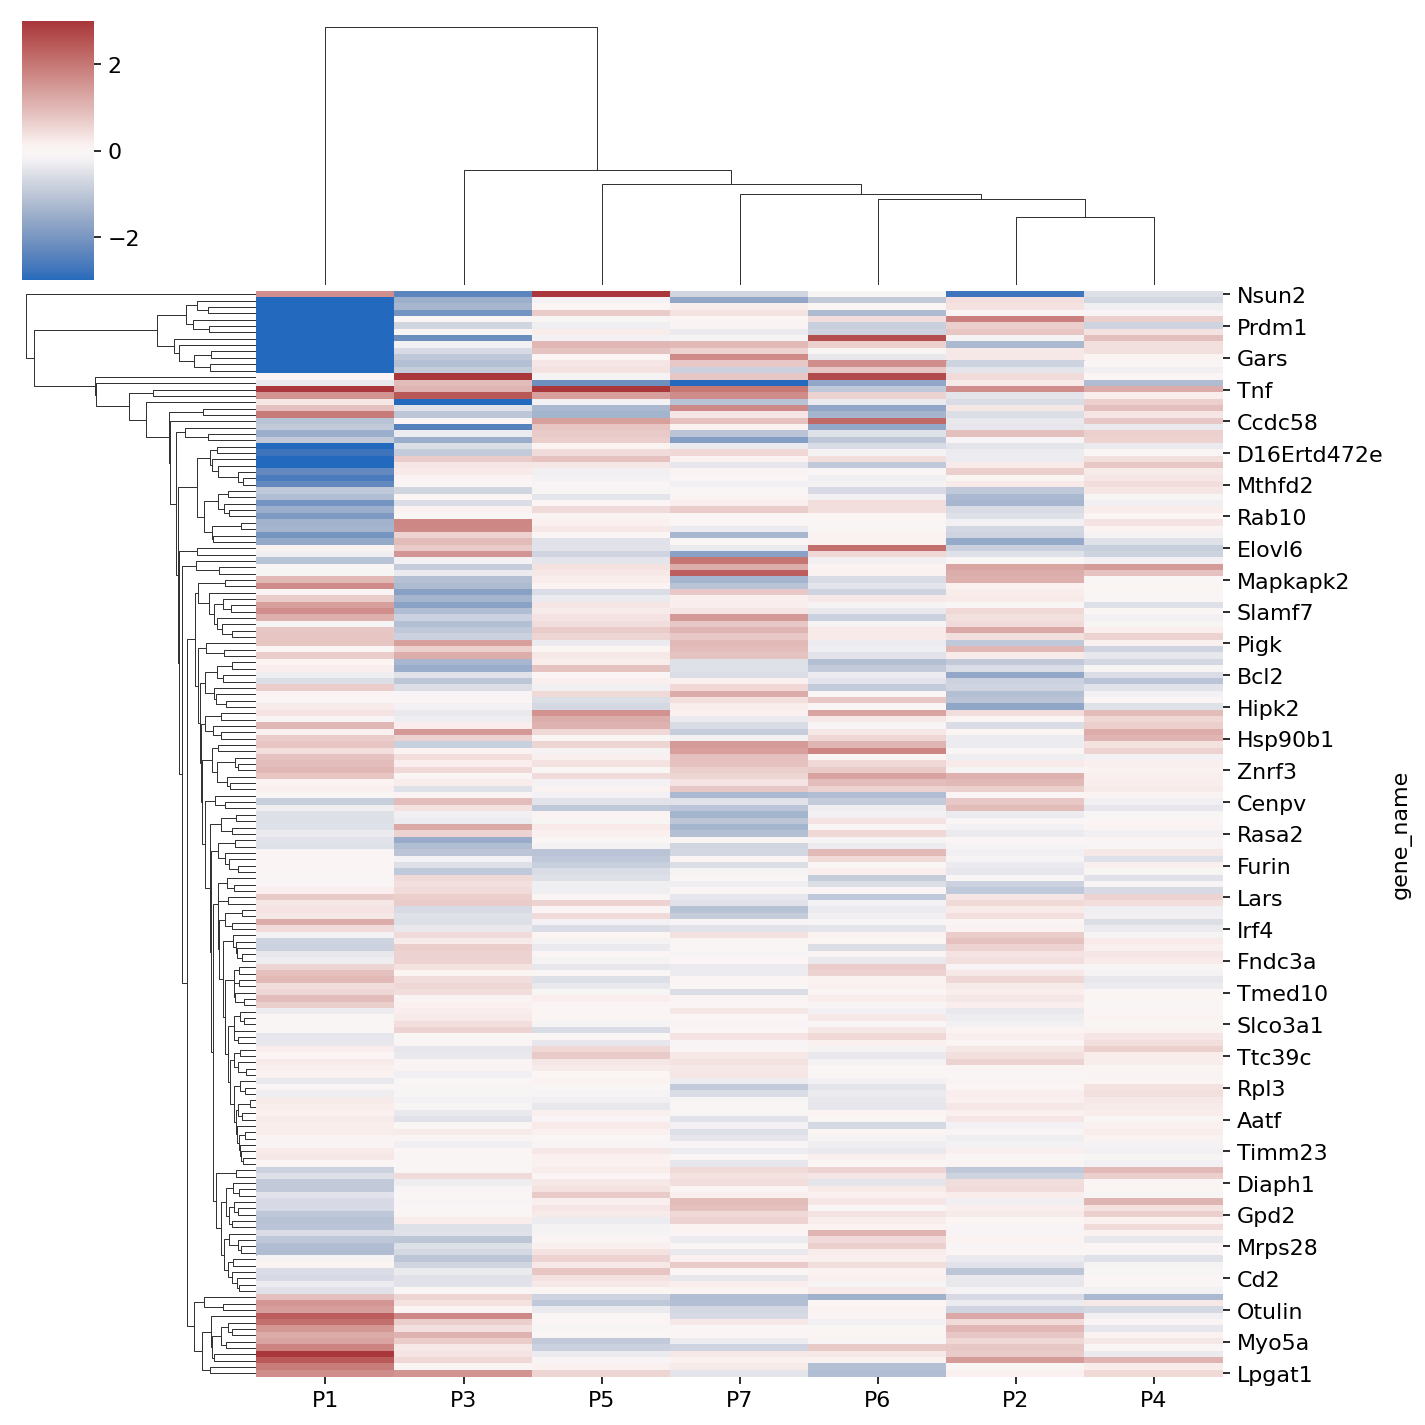

In [171]:
Il2ra_prom_wt_df = layer_group_average_slt_genes(adata_act_wt, "Mu",il2ra_prom_genes, 
                              'louvain', louvain_new_ordered_simp[1:], "WT" )
Il2ra_prom_ko_df = layer_group_average_slt_genes(adata_act_ko, "Mu",il2ra_prom_genes, 
                              'louvain', louvain_new_ordered_simp[1:], "KO" )
Il2ra_prom_genes_use = list(set(Il2ra_prom_wt_df.index.tolist()) & set(Il2ra_prom_ko_df.index.tolist()))

# Reorder to the same row order
Il2ra_prom_wt_df = Il2ra_prom_wt_df.loc[Il2ra_prom_genes_use]
Il2ra_prom_ko_df = Il2ra_prom_ko_df.loc[Il2ra_prom_genes_use]

fc_df = pd.DataFrame({'gene_name': Il2ra_prom_genes_use}).set_index("gene_name")
for i in louvain_new_ordered_simp[1:]:
    i_fc = (Il2ra_prom_wt_df['WT_%s'%i].values + 0.0001) /  (Il2ra_prom_ko_df['KO_%s'%i].values + 0.0001)
    i_log2fc = np.log2(i_fc)
    fc_df[i] = i_log2fc
    
wt_he = Il2ra_prom_wt_df.index[Il2ra_prom_wt_df.max(axis=1) > 0.1]
ko_he = Il2ra_prom_ko_df.index[Il2ra_prom_ko_df.max(axis=1) > 0.1]
he_genes = list(set(wt_he) | set(ko_he))

hm = sns.clustermap(fc_df.loc[he_genes], cmap='vlag', vmax=3, vmin=-3)

plt.savefig(out_dir + "/Il2ra_promoted_Mu_log2fc.png")
hm.data2d.to_csv(out_dir + "/Il2ra_promoted_Mu_log2fc.csv")

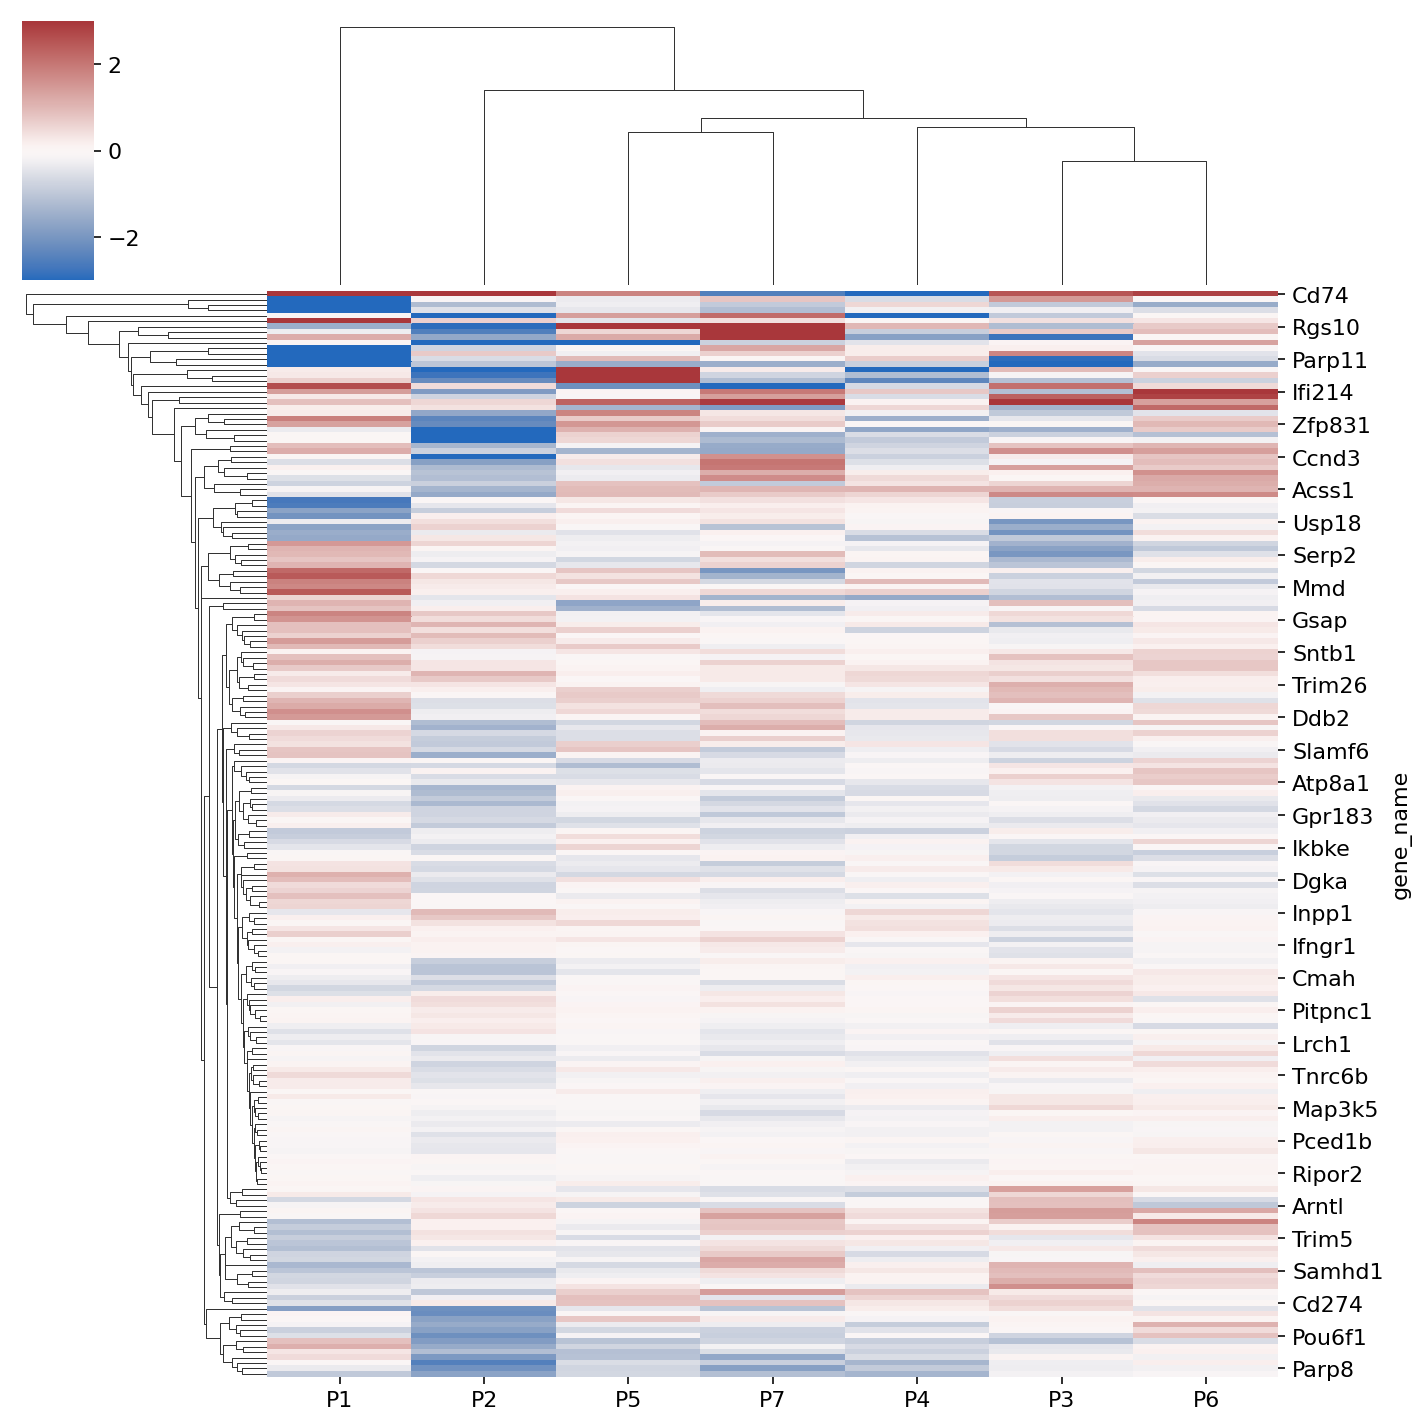

In [172]:
Il2ra_repr_wt_df = layer_group_average_slt_genes(adata_act_wt, "Mu",il2ra_repr_genes, 
                              'louvain', louvain_new_ordered_simp[1:], "WT" )
Il2ra_repr_ko_df = layer_group_average_slt_genes(adata_act_ko, "Mu",il2ra_repr_genes, 
                              'louvain', louvain_new_ordered_simp[1:], "KO" )
Il2ra_repr_genes_use = list(set(Il2ra_repr_wt_df.index.tolist()) & set(Il2ra_repr_ko_df.index.tolist()))

# Reorder to the same row order
Il2ra_repr_wt_df = Il2ra_repr_wt_df.loc[Il2ra_repr_genes_use]
Il2ra_repr_ko_df = Il2ra_repr_ko_df.loc[Il2ra_repr_genes_use]

fc_df = pd.DataFrame({'gene_name': Il2ra_repr_genes_use}).set_index("gene_name")
for i in louvain_new_ordered_simp[1:]:
    i_fc = (Il2ra_repr_wt_df['WT_%s'%i].values + 0.0001) /  (Il2ra_repr_ko_df['KO_%s'%i].values + 0.0001)
    i_log2fc = np.log2(i_fc)
    fc_df[i] = i_log2fc
    
wt_he = Il2ra_repr_wt_df.index[Il2ra_repr_wt_df.max(axis=1) > 0.1]
ko_he = Il2ra_repr_ko_df.index[Il2ra_repr_ko_df.max(axis=1) > 0.1]
he_genes = list(set(wt_he) | set(ko_he))

hm = sns.clustermap(fc_df.loc[he_genes], cmap='vlag', vmax=3, vmin=-3)

plt.savefig(out_dir + "/Il2ra_repressed_Mu_log2fc.png")
hm.data2d.to_csv(out_dir + "/Il2ra_repressed_Mu_log2fc.csv")

# TRM / Tstem signature genes

In [333]:
p5_wt_ko = base_dir + '/1_IL2RAKO/1_Scanpy/0-all_Scanpy_out/2_DE/perCluster_KO_vs_WT/P5/CD25WT/CD25WT_vs_CD25KO_differential.csv'
p5_wt_ko_df = pd.read_csv(p5_wt_ko, index_col=0)
p5_wt_ko_genes = p5_wt_ko_df[np.abs(p5_wt_ko_df['wilcoxon_logfc']) > 1].index.tolist()

p3_wt_ko = base_dir + '/1_IL2RAKO/1_Scanpy/0-all_Scanpy_out/2_DE/perCluster_KO_vs_WT/P3/CD25WT/CD25WT_vs_CD25KO_differential.csv'
p3_wt_ko_df = pd.read_csv(p3_wt_ko, index_col=0)
p3_wt_ko_genes = p3_wt_ko_df[np.abs(p3_wt_ko_df['wilcoxon_logfc']) > 1].index.tolist()

p2_wt_ko = base_dir + '/1_IL2RAKO/1_Scanpy/0-all_Scanpy_out/2_DE/perCluster_KO_vs_WT/P2/CD25WT/CD25WT_vs_CD25KO_differential.csv'
p2_wt_ko_df = pd.read_csv(p2_wt_ko, index_col=0)
p2_wt_ko_genes = p2_wt_ko_df[np.abs(p2_wt_ko_df['wilcoxon_logfc']) > 1].index.tolist()

In [319]:
sig_file = '/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/X_GeneSignatures_mm/all_mouse_T_cell_signatures.csv'
sig_df = pd.read_csv(sig_file)

trm_gsname = '2016_SCIENCE_Mackay---TRM_vs_TCM-TEM'
trm_genes = sig_df[sig_df['gs_name'] == trm_gsname]['gene_symbol'].tolist()
tstem_gsname = 'Exp391_CD8---Yao_PRO'
tstem_genes = sig_df[sig_df['gs_name'] == tstem_gsname]['gene_symbol'].tolist()

In [323]:
out_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/9_Figures/1_IL2RAKO/0_all/GSEA_heatmaps'

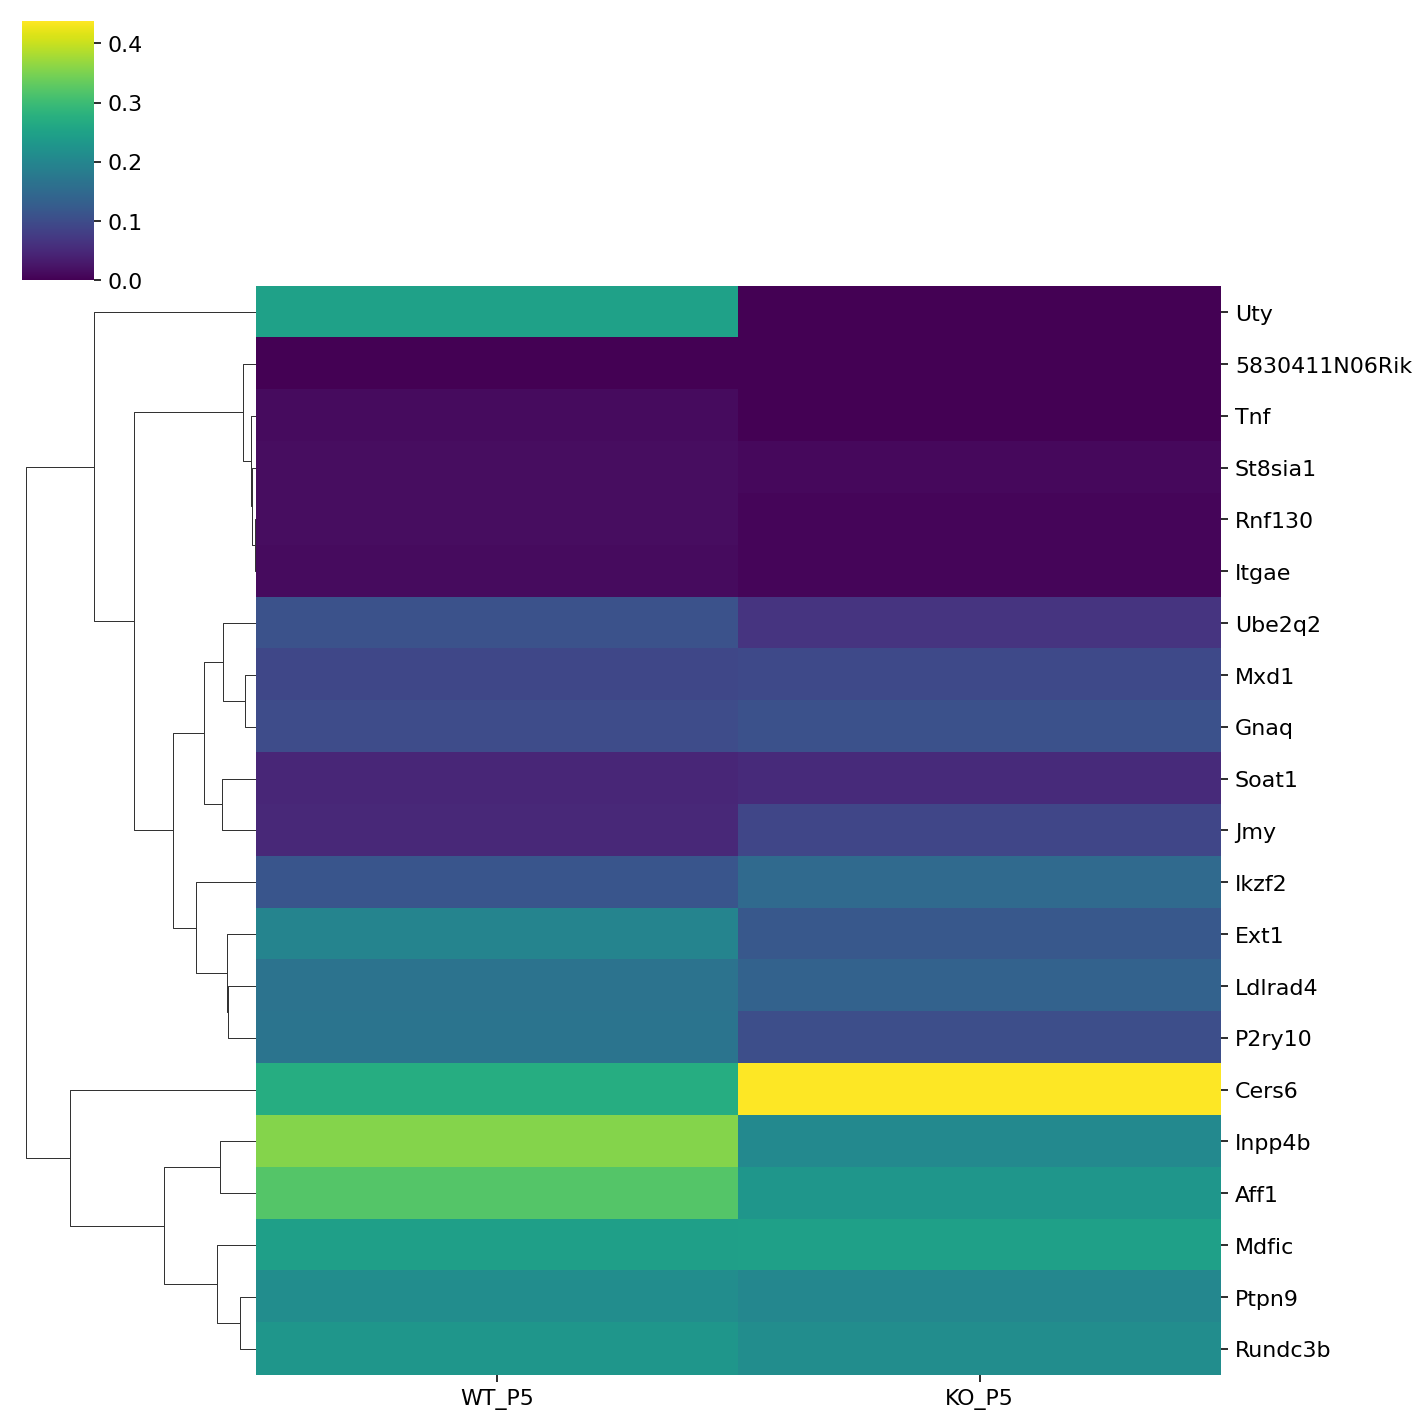

In [329]:
### TRM & P5 diff genes
trm_p5_genes = set(p5_wt_ko_genes) & set(trm_genes)

trm_wt_df = layer_group_average_slt_genes(adata_act_wt, "Mu",trm_p5_genes, 
                              'louvain', ['P5'], "WT" )
trm_ko_df = layer_group_average_slt_genes(adata_act_ko, "Mu",trm_p5_genes, 
                              'louvain', ['P5'], "KO" )
plot_df = trm_wt_df.join(trm_ko_df)
plot_df_he = plot_df[plot_df.max(axis=1) > 0.0001]
hm = sns.clustermap(plot_df_he, cmap='viridis', col_cluster=False)
hm.data2d.to_csv(out_dir + "/P5-WT-KO_trm-signature_Mu.csv")
plt.savefig(out_dir + "/P5-WT-KO_trm-signature_Mu.png")

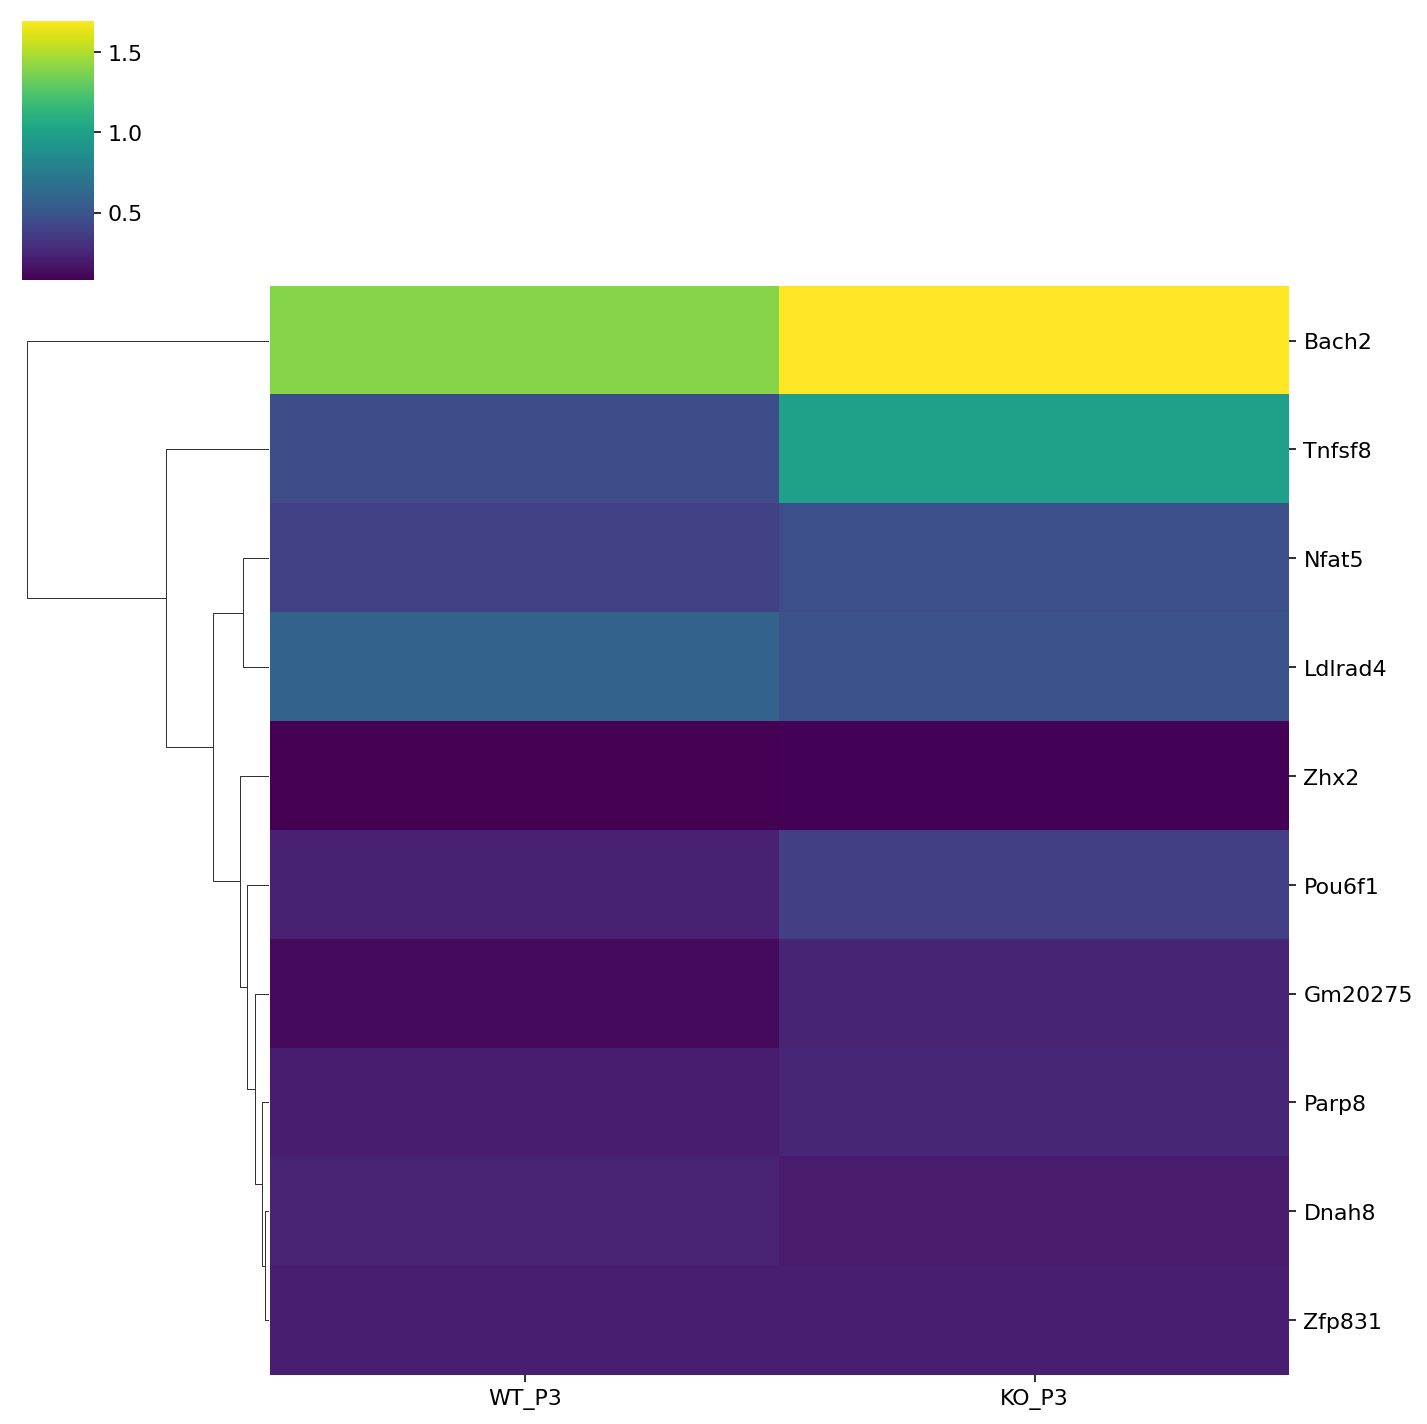

In [335]:
### Tstem & P3 diff genes
tstem_p3_genes = set(p3_wt_ko_genes) & set(tstem_genes)

tstem_wt_df = layer_group_average_slt_genes(adata_act_wt, "Mu",tstem_p3_genes, 
                              'louvain', ['P3'], "WT" )
tstem_ko_df = layer_group_average_slt_genes(adata_act_ko, "Mu",tstem_p3_genes, 
                              'louvain', ['P3'], "KO" )
plot_df = tstem_wt_df.join(tstem_ko_df)
plot_df_he = plot_df[plot_df.max(axis=1) > 0.0001]
hm = sns.clustermap(plot_df_he, cmap='viridis', col_cluster=False)
hm.data2d.to_csv(out_dir + "/P3-WT-KO_Tstem-signature_Mu.csv")
plt.savefig(out_dir + "/P3-WT-KO_Tstem-signature_Mu.png")

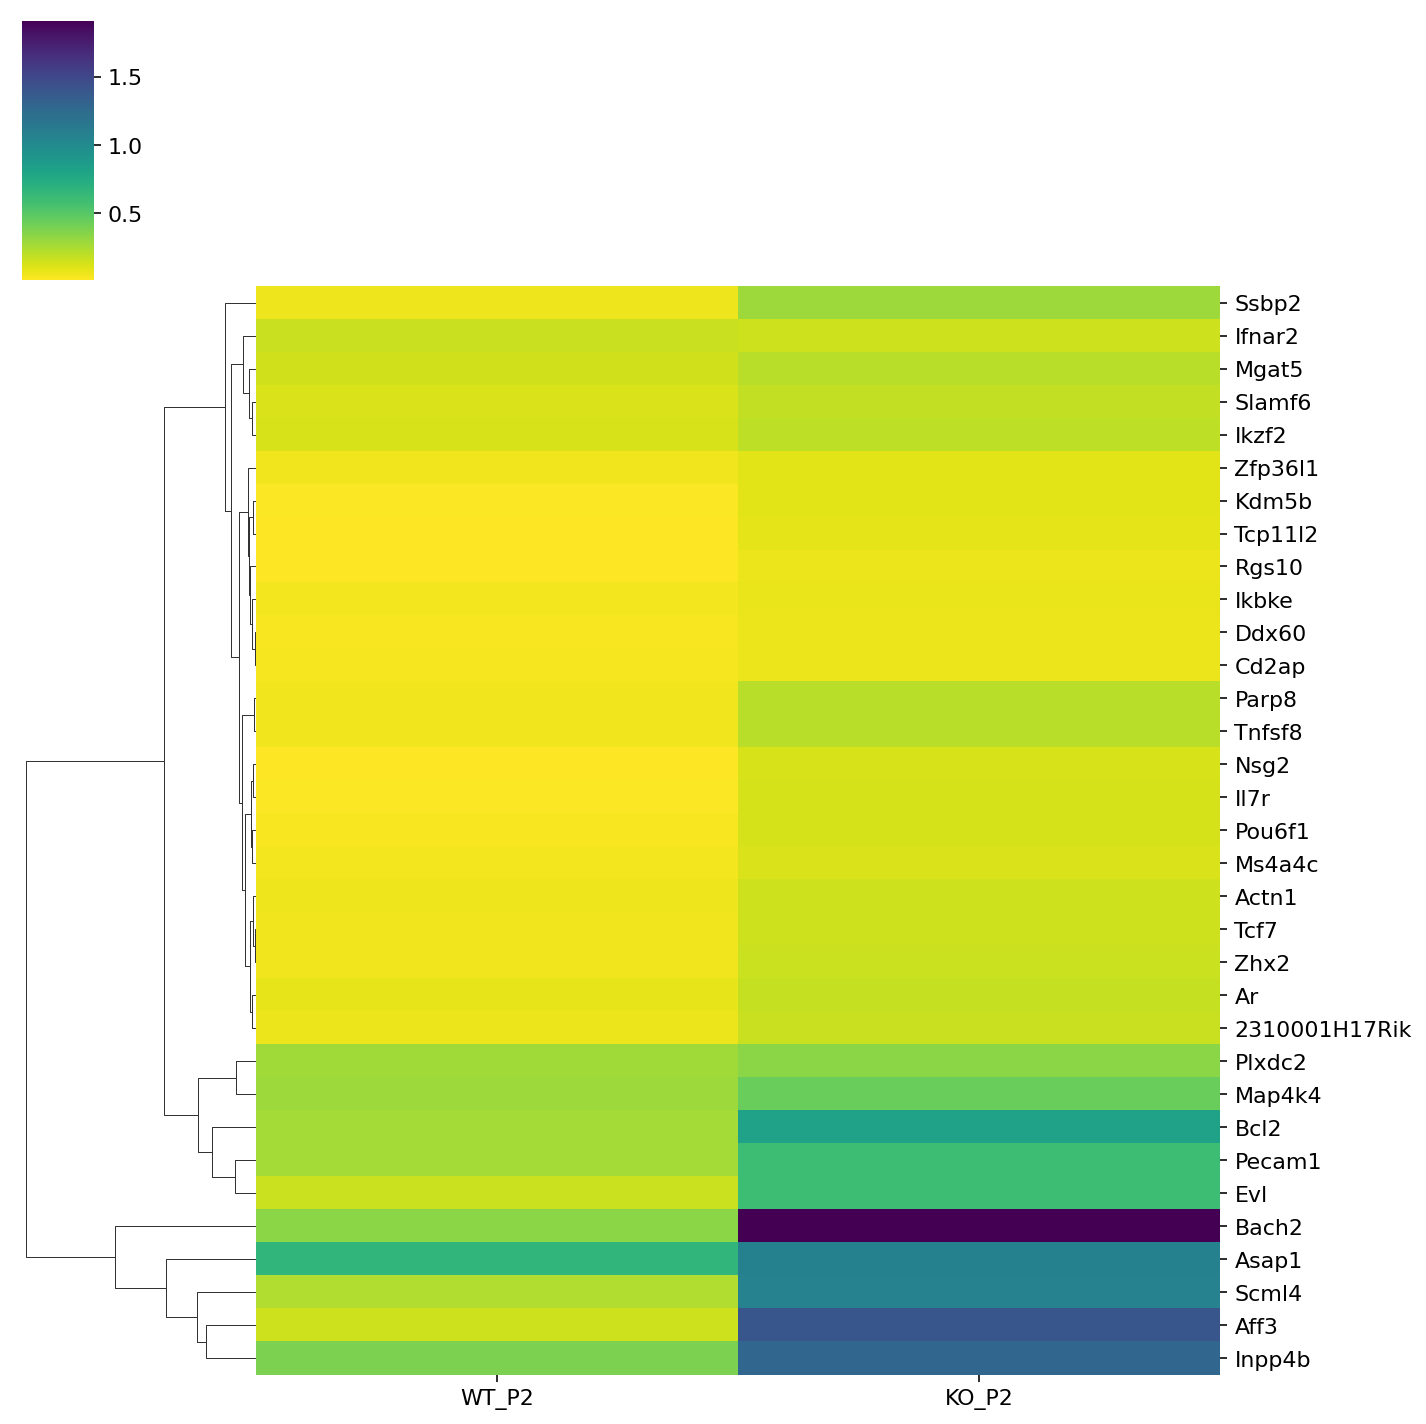

In [330]:
### TSTEM & P2 diff genes
tstem_p2_genes = set(p2_wt_ko_genes) & set(tstem_genes)

tstem_wt_df = layer_group_average_slt_genes(adata_act_wt, "Mu",tstem_p2_genes, 
                              'louvain', ['P2'], "WT" )
tstem_ko_df = layer_group_average_slt_genes(adata_act_ko, "Mu",tstem_p2_genes, 
                              'louvain', ['P2'], "KO" )
plot_df = tstem_wt_df.join(tstem_ko_df)
plot_df_he = plot_df[plot_df.max(axis=1) > 0.05]
hm = sns.clustermap(plot_df_he, cmap='viridis_r', col_cluster=False)
hm.data2d.to_csv(out_dir + "/P2-WT-KO_tstem-signature_Mu.csv")
plt.savefig(out_dir + "/P2-WT-KO_tstem-signature_Mu.png")

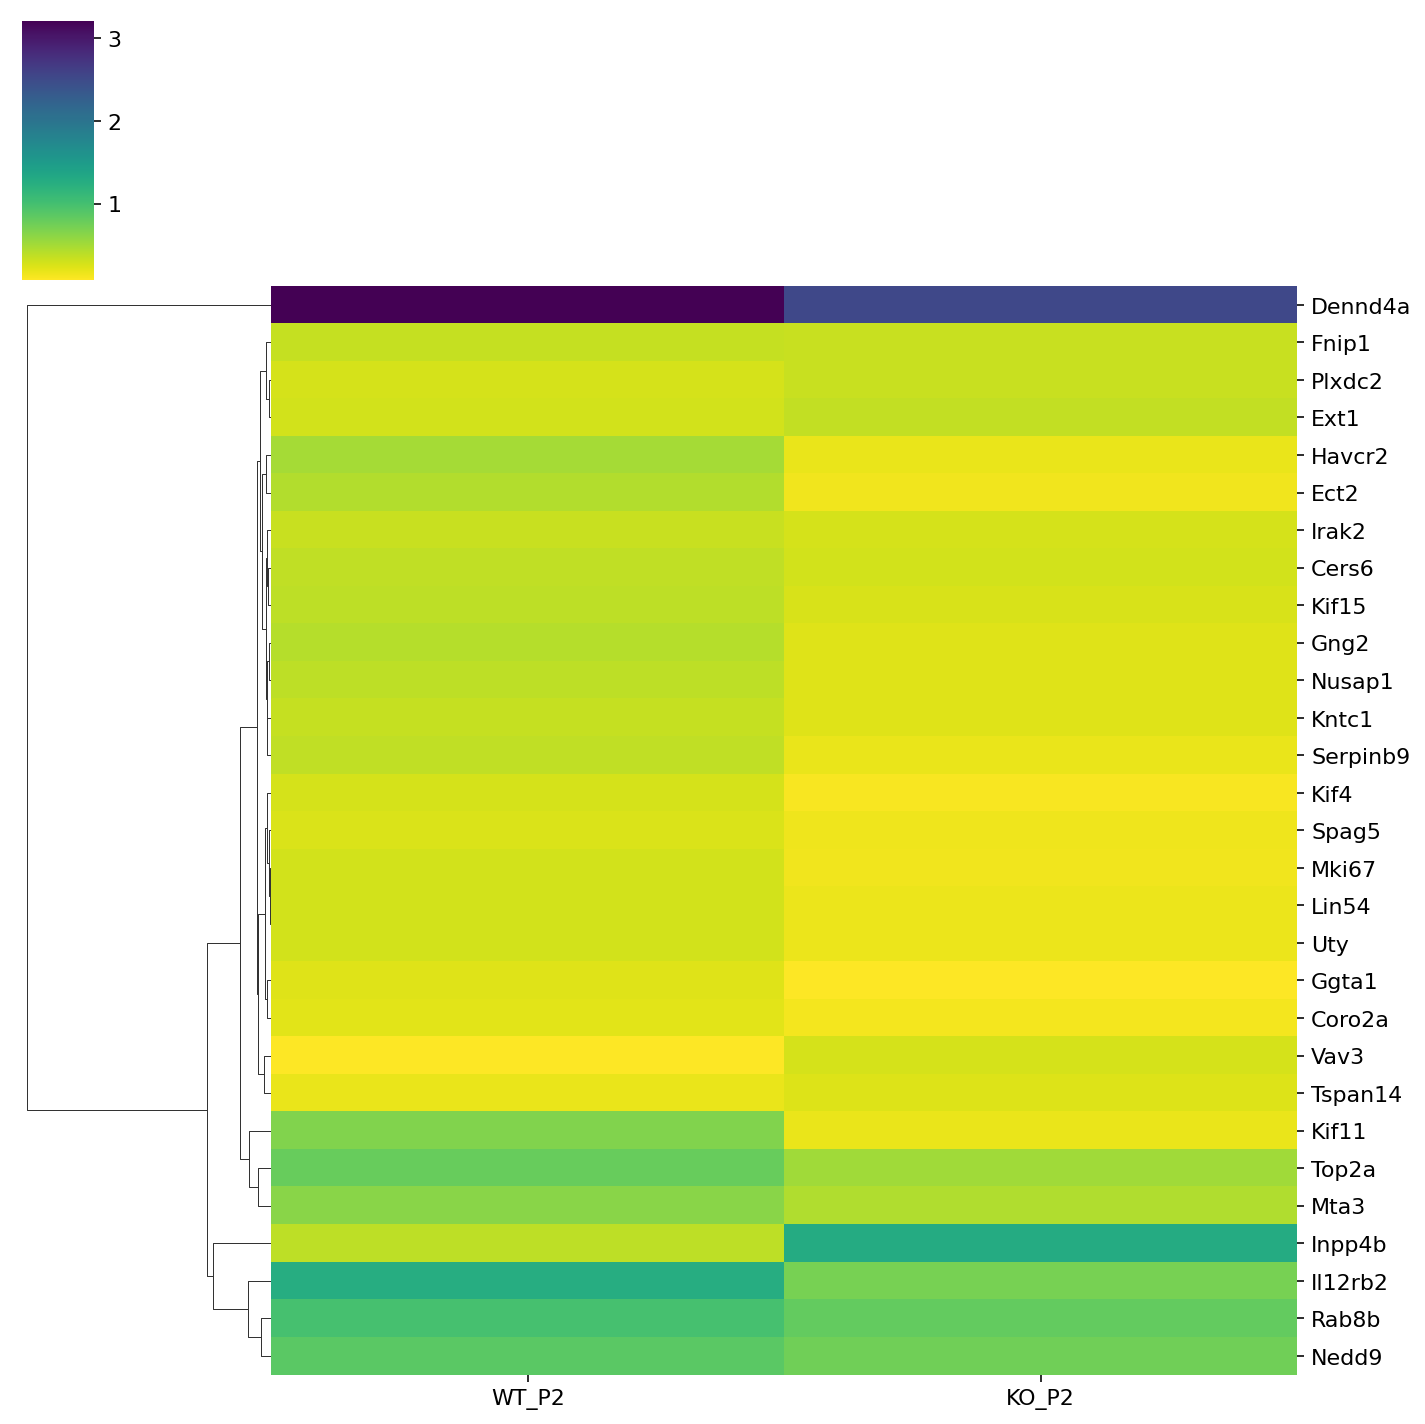

In [331]:
### TRM & P2 diff genes
trm_p2_genes = set(p2_wt_ko_genes) & set(trm_genes)

trm_wt_df = layer_group_average_slt_genes(adata_act_wt, "Mu",trm_p2_genes, 
                              'louvain', ['P2'], "WT" )
trm_ko_df = layer_group_average_slt_genes(adata_act_ko, "Mu",trm_p2_genes, 
                              'louvain', ['P2'], "KO" )
plot_df = trm_wt_df.join(trm_ko_df)
plot_df_he = plot_df[plot_df.max(axis=1) > 0.2]
hm = sns.clustermap(plot_df_he, cmap='viridis_r', col_cluster=False)
hm.data2d.to_csv(out_dir + "/P2-WT-KO_trm-signature_Mu.csv")
plt.savefig(out_dir + "/P2-WT-KO_trm-signature_Mu.png")